In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from irt import IRTModel
from sklearn import svm
from sklearn.linear_model import SGDRegressor, LinearRegression, BayesianRidge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

# 1. Fuel Consumption (MPG)

"The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes." (Quinlan, 1993)


Attribute Information:

1. mpg: continuous 
2. cylinders: multi-valued discrete 
3. displacement: continuous 
4. horsepower: continuous 
5. weight: continuous 
6. acceleration: continuous 
7. model year: multi-valued discrete 
8. origin: multi-valued discrete 
9. car name: string (unique for each instance)

In [3]:
names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name']
data = pd.read_csv('data/UCI - 45/auto_mpg.csv')
data.columns = names

In [4]:
data = data.dropna()

In [5]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,16.0,8,304.0,150.0,3433,12.0,70,1,amcrebelsst
1,15.0,8,390.0,190.0,3850,8.5,70,1,amcambassadordpl
2,18.0,6,199.0,97.0,2774,15.5,70,1,amchornet
3,21.0,6,199.0,90.0,2648,15.0,70,1,amcgremlin
4,19.0,6,232.0,100.0,2634,13.0,71,1,amcgremlin


### Correlation Heatmap

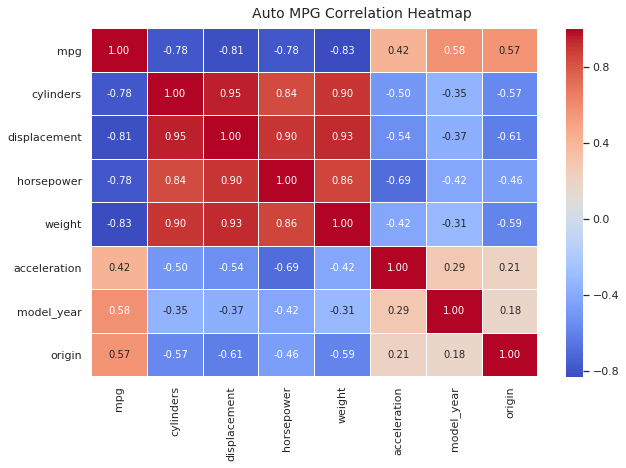

In [6]:
# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(10, 6))
corr = data.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Auto MPG Correlation Heatmap', fontsize=14)

### 3D Scatter Plot - Displacement x Weight x MPG

Text(0.5, 0, 'MPG')

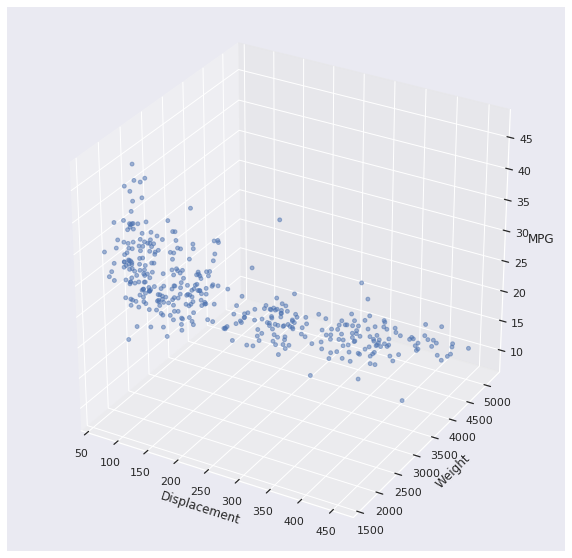

In [7]:
# Visualizing 3-D numeric data with Scatter Plots
# length, breadth and depth
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data['displacement'], data['weight'], data['mpg'], s=15, alpha=0.5)

ax.set_xlabel('Displacement')
ax.set_ylabel('Weight')
ax.set_zlabel('MPG')

### Item Response Theory

In [8]:
X = data.iloc[:, 1:-3]
y = data.iloc[:, 0]

Random split:

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

Machine learning models:

In [10]:
models = [LinearRegression(), BayesianRidge(), Lasso(), svm.SVR(kernel= 'linear'), svm.SVR(kernel = 'rbf'),\
     KNeighborsRegressor(), DecisionTreeRegressor(), RandomForestRegressor(),\
          AdaBoostRegressor(), MLPRegressor()]

Item-Response Matrix:

In [13]:
irt = IRTModel(models= models)
irt.fit(X_train= X_train, y_train= y_train)
irt.irtMatrix(X_test= X_test, y_test= y_test, normalize = True)

In [14]:
irt.irt_matrix[79]

LinearRegression         0.577433
BayesianRidge            0.580996
Lasso                    0.566185
SVR                      0.323798
SVR                      0.566158
KNeighborsRegressor      0.929129
DecisionTreeRegressor    0.919108
RandomForestRegressor    0.839847
AdaBoostRegressor        0.821883
MLPRegressor             0.615447
Name: 79, dtype: float64

In [15]:
irt.irt_matrix

,79,278,250,56,393,207,43,237,153,117,...,5,46,85,243,111,367,83,115,3,18
LinearRegression,0.577433,0.672698,0.357807,0.336293,0.709328,0.924944,0.506341,0.827678,0.586499,0.817625,...,0.590982,0.128489,0.829804,0.257612,0.824794,0.643713,0.888984,0.732116,0.369252,0.555302
BayesianRidge,0.580996,0.628632,0.357393,0.334381,0.705007,0.907544,0.482410,0.824795,0.580459,0.826161,...,0.610432,0.123450,0.824210,0.295995,0.839944,0.646259,0.948485,0.744524,0.372591,0.583871
Lasso,0.566185,0.651108,0.361930,0.336380,0.705993,0.911400,0.497880,0.820513,0.578418,0.814069,...,0.597163,0.129608,0.826224,0.290519,0.836803,0.641852,0.957566,0.736008,0.365007,0.561691
SVR,0.323798,0.608283,0.387254,0.265625,0.790985,0.703977,0.444206,0.858666,0.508609,0.458541,...,0.438260,0.404360,0.858210,0.164171,0.822410,0.629836,0.563698,0.740025,0.276303,0.362107
SVR,0.566158,0.527243,0.556735,0.556735,0.477597,0.520941,0.679369,0.520941,0.518949,0.540559,...,0.536142,0.890262,0.476912,0.298974,0.526518,0.484054,0.546205,0.480064,0.579335,0.544156
KNeighborsRegressor,0.929129,0.710562,0.315501,0.508365,0.628461,0.868521,0.316365,0.876201,0.697990,0.946511,...,0.960967,0.116362,0.885422,0.808579,0.868257,0.630042,0.845563,0.844953,0.333994,0.830756
DecisionTreeRegressor,0.919108,0.962540,0.317552,0.224522,1.000000,0.908329,0.455968,0.798527,0.703391,0.929931,...,0.628001,0.122644,0.677456,0.144542,0.798156,0.601819,0.854773,0.502393,1.000000,0.803556
RandomForestRegressor,0.839847,0.516020,0.336700,0.432915,0.800969,0.925294,0.384009,0.990009,0.684844,0.829651,...,0.924866,0.215896,0.995141,0.225597,0.831732,0.602419,0.905744,0.604700,0.771800,0.929906
AdaBoostRegressor,0.821883,0.684000,0.313504,0.427938,0.765053,0.865850,0.309613,0.869762,0.646681,0.918348,...,0.834882,0.183612,0.762278,0.247567,0.944489,0.599455,0.793772,0.800691,0.338999,0.854594
MLPRegressor,0.615447,0.285426,0.311012,0.427429,0.607044,0.772786,0.412476,0.925458,0.926368,0.444510,...,0.889175,0.089529,0.531188,0.875116,0.866637,0.482176,0.807262,0.571224,0.365083,0.652767


### 2D Scatter Plots (Displacement, Weight, Acceleration, MPG)

In [14]:
types = list(y_test.index)

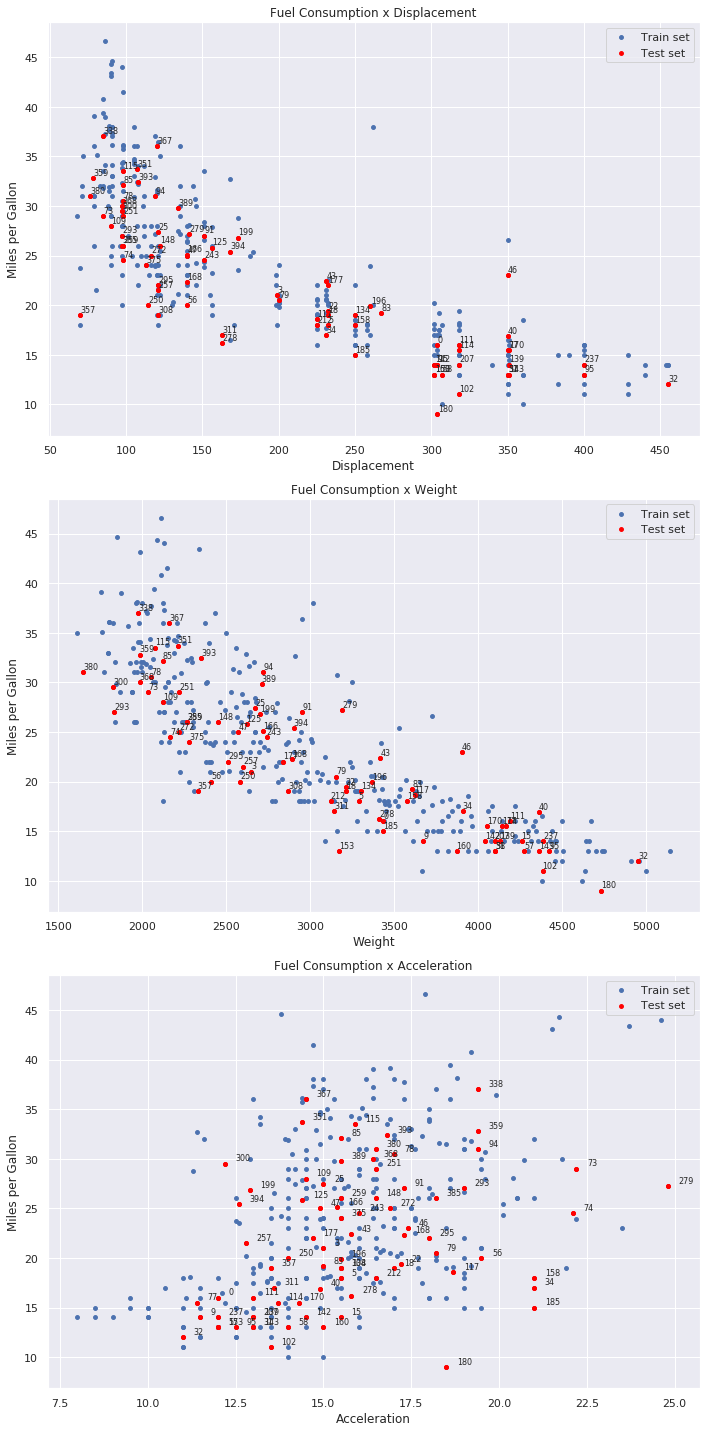

In [15]:
plt.figure(figsize=(10,20))
size = 15
ind = [1, 3, 4]
X_names = ['Displacement', 'Weight', 'Acceleration']

for i, name in enumerate(X_names):
    plt.subplot(3, 1, i+1)
    plt.scatter(X_train.iloc[:, ind[i]], y_train, s=size, label = 'Train set')
    for j, t in enumerate(types):
        x = X_test.iloc[j, ind[i]]
        y = y_test.iloc[j]
        plt.scatter(x, y, color='red', s=size)
        plt.text(x+0.3, y+0.3, t, fontsize=8)
    plt.scatter(X_test.iloc[:, ind[i]], y_test, s=size, c= 'red', label = 'Test set')
    plt.title('Fuel Consumption x '+ name)
    plt.xlabel(name)
    plt.ylabel('Miles per Gallon')
    plt.legend()

plt.tight_layout()
plt.show()

Search for instance:

In [16]:
instance = 367
irt.irt_matrix[instance]

LinearRegression         0.129998
BayesianRidge            0.131261
Lasso                    0.129084
SVR                      0.123361
SVR                      0.072005
KNeighborsRegressor      0.123457
DecisionTreeRegressor    0.111111
RandomForestRegressor    0.095238
AdaBoostRegressor        0.101410
MLPRegressor             0.061683
Name: 367, dtype: float64

# 2. Cycle Power Plant (MW)

The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP) of the plant.Features consist of hourly average ambient variables

Attribute Information:
 
1. Temperature (T) in the range 1.81°C and 37.11°C,
2. Ambient Pressure (AP) in the range 992.89-1033.30 milibar,
3. Relative Humidity (RH) in the range 25.56% to 100.16%
4. Exhaust Vacuum (V) in teh range 25.36-81.56 cm Hg
5. Net hourly electrical energy output (EP) 420.26-495.76 MW

The averages are taken from various sensors located around the plant that record the ambient variables every second. The variables are given without normalization.

In [17]:
df = pd.read_csv('data/UCI - 45/cycle_power_plant.csv')
names1 = ['amb_temperature', 'ambient_pressure', 'relative_humidity', 'exhaust_vacuum', 'energy_output']
df.columns = names1

In [18]:
df.head()

,amb_temperature,ambient_pressure,relative_humidity,exhaust_vacuum,energy_output
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


### Correlation Heatmap

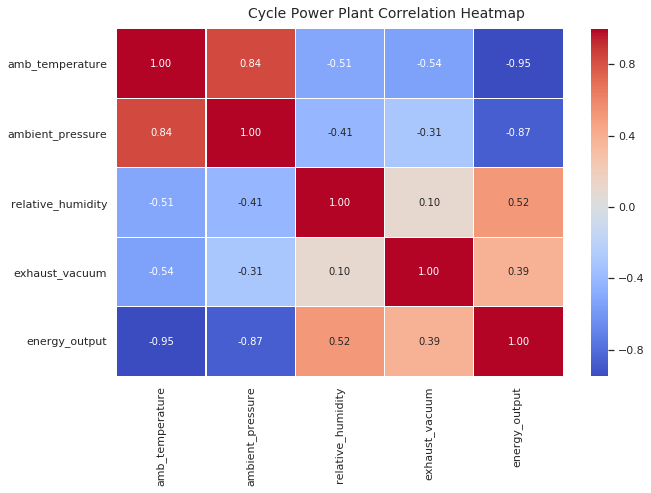

In [19]:
# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(10, 6))
corr = df.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Cycle Power Plant Correlation Heatmap', fontsize=14)

Text(0.5, 0, 'Energy Output (MW)')

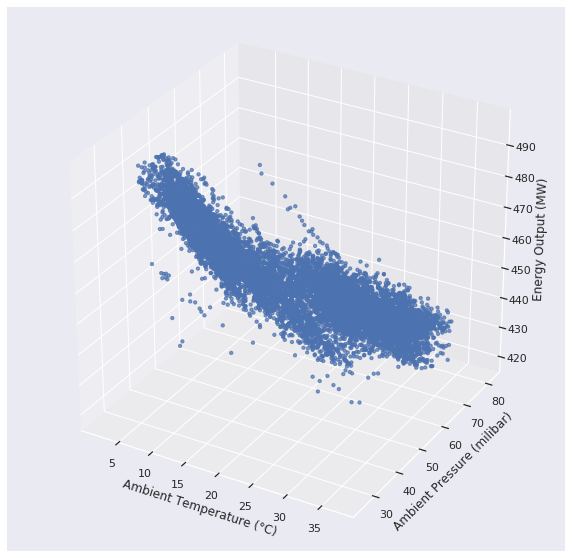

In [20]:
# Visualizing 3-D numeric data with Scatter Plots
# length, breadth and depth
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['amb_temperature'], df['ambient_pressure'], df['energy_output'], s=10, alpha=0.2)

ax.set_xlabel('Ambient Temperature (°C)')
ax.set_ylabel('Ambient Pressure (milibar)')
ax.set_zlabel('Energy Output (MW)')

### Item Response Theory

In [21]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
models = [LinearRegression(), BayesianRidge(), Lasso(), svm.SVR(kernel= 'linear'), svm.SVR(kernel = 'rbf'),\
     KNeighborsRegressor(), DecisionTreeRegressor(), RandomForestRegressor(),\
          AdaBoostRegressor(), MLPRegressor()]

In [24]:
irt = IRTModel(models= models)
irt.fit(X_train= X_train, y_train= y_train)
irt.irtMatrix(X_test= X_test, y_test= y_test)

In [25]:
irt.irt_matrix

,19822,43826,3187,21666,43132,30428,42175,25504,40178,27192,...,10466,40899,29800,28650,43983,38102,3887,29878,10562,23877
LinearRegression,0.059824,0.183146,0.128264,0.561801,0.348347,0.255354,0.123987,0.197543,0.138407,0.409693,...,0.286611,0.151529,0.135590,0.447984,0.175756,0.532898,0.175710,0.135764,0.385903,0.211892
BayesianRidge,0.059824,0.183155,0.128264,0.561810,0.348291,0.255354,0.123991,0.197548,0.138415,0.409700,...,0.286598,0.151545,0.135600,0.447988,0.175749,0.532873,0.175716,0.135756,0.385948,0.211883
Lasso,0.058447,0.200482,0.130699,0.440195,0.317825,0.269508,0.130018,0.200869,0.139867,0.434707,...,0.283097,0.168821,0.139411,0.439999,0.177322,0.469315,0.174975,0.129074,0.437970,0.204644
SVR,0.064472,0.158693,0.122729,0.721919,0.411165,0.225738,0.114541,0.200040,0.144454,0.342706,...,0.267261,0.122990,0.133084,0.491956,0.166829,0.737505,0.176115,0.148772,0.307038,0.220117
SVR,0.070837,0.474360,0.909273,0.068646,0.909019,0.908830,0.394223,0.579418,0.154230,0.908817,...,0.909054,0.053867,0.517993,0.534339,0.241055,0.689029,0.706275,0.225440,0.126771,0.482234
KNeighborsRegressor,0.815661,0.976562,0.604595,0.582072,0.899281,0.957854,0.763359,0.262605,0.591716,0.657895,...,0.611995,0.638570,0.830565,0.584795,0.850340,0.783699,0.936330,0.512821,0.621891,0.534759
DecisionTreeRegressor,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
RandomForestRegressor,1.000000,1.000000,1.000000,1.000000,1.000000,0.863558,1.000000,1.000000,0.743494,1.000000,...,0.933707,1.000000,0.936330,1.000000,1.000000,0.843170,1.000000,1.000000,1.000000,0.775194
AdaBoostRegressor,0.057401,0.168512,0.199696,0.276788,0.296081,0.368462,0.153038,0.093235,0.150597,0.242006,...,0.371778,0.370615,0.117771,0.232884,0.462304,0.542633,0.478453,0.150900,0.424773,0.592458
MLPRegressor,0.071427,0.110116,0.125447,0.300941,0.839896,0.226238,0.084244,0.214385,0.210363,0.212222,...,0.228356,0.176586,0.135012,0.935992,0.130373,0.578685,0.217767,0.137139,0.239889,0.183173


### 2D Scatter Plots (Ambient Temperature, Ambient Pressure, Relative Humidity and Energy Output)

In [26]:
types = list(y_test.index)

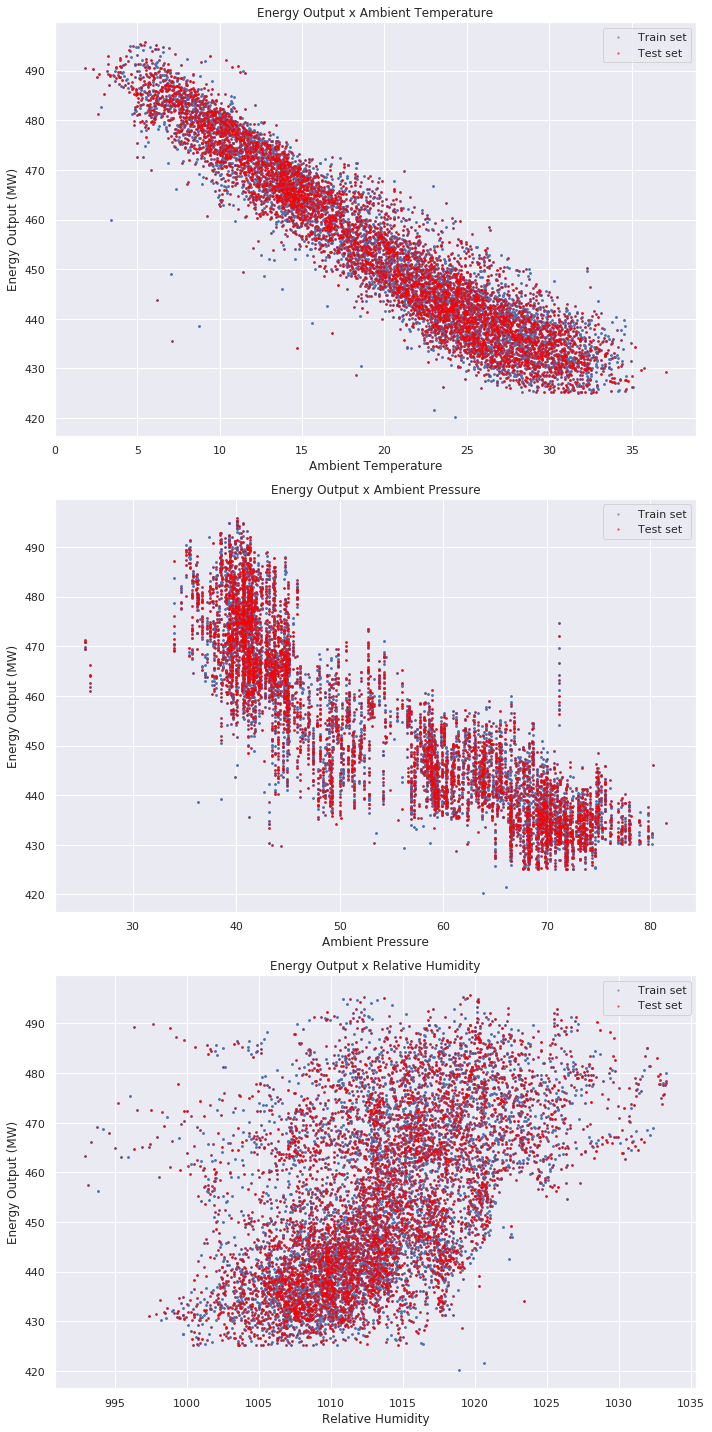

In [27]:
plt.figure(figsize=(10,20))
size = 2
ind = [0, 1, 2]
X_names = ['Ambient Temperature', 'Ambient Pressure', 'Relative Humidity']

for i, name in enumerate(X_names):
    plt.subplot(3, 1, i+1)
    plt.scatter(X_train.iloc[:, ind[i]], y_train, s=size, label = 'Train set', alpha = 0.5)
#     for j, t in enumerate(types):
#         x = X_test.iloc[j, ind[i]]
#         y = y_test.iloc[j]
#         plt.scatter(x, y, color='red', s=size)
#         plt.text(x+0.3, y+0.3, t, fontsize=8)
    plt.scatter(X_test.iloc[:, ind[i]], y_test, s=size, c= 'red', label = 'Test set', alpha = 0.5)
    plt.title('Energy Output x '+ name)
    plt.xlabel(name)
    plt.ylabel('Energy Output (MW)')
    plt.legend()

plt.tight_layout()
plt.show()